In [181]:
import pandas as pd
import os
import plotting
import importlib
importlib.reload(plotting)
pd.options.display.max_rows = 4000
import numpy as np

In [182]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

In [183]:
# ylabel_name = 'marions_ylabels_esd_removed'
ylabel_name = 'marions_ylabels'
data_features = pd.read_csv("data/optimal_features.csv")
clustering_features = plotting.extract_numerical_features(data_features)

In [184]:
# ylabel_name = 'marions_ylabels_deduction'
ylabel_to_cluster_num = {'Outlier':-1, 'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
cluster_num_to_ylabel = {v: k for k, v in ylabel_to_cluster_num.items()}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
marions_labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data

# Split Based on Popcorn

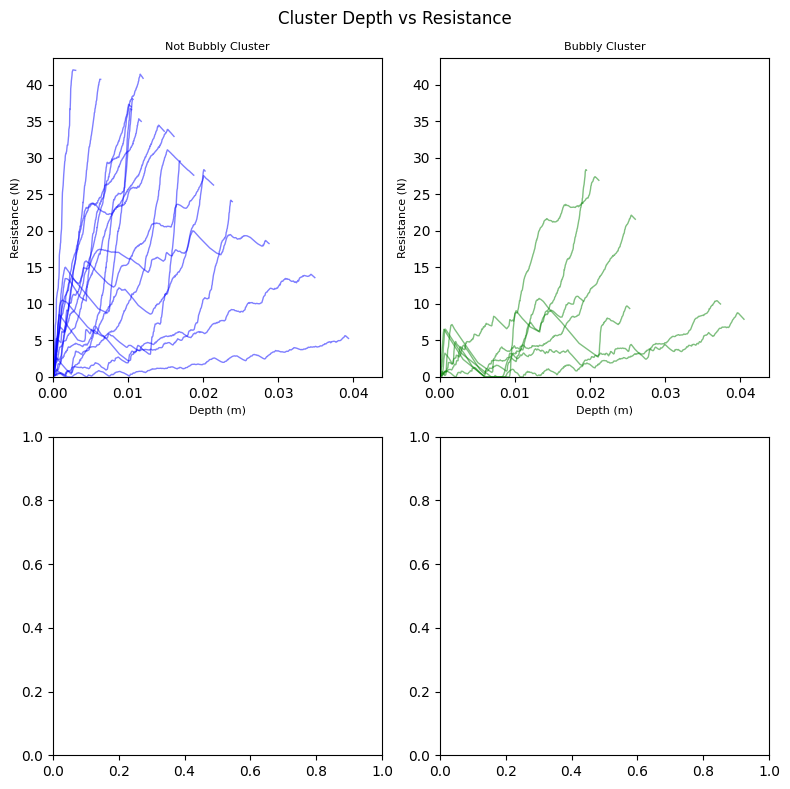

In [185]:
data_with_popcorn_label = data_features[data_features['popcorn'].notna()]
numerical_features = plotting.extract_numerical_features(data_with_popcorn_label)
predictions = data_with_popcorn_label['popcorn'].astype(int)+2 # +2 to change the colors
true_centroid = numerical_features[data_with_popcorn_label['popcorn'] == True].mean(axis=0)
false_centroid = numerical_features[data_with_popcorn_label['popcorn'] == False].mean(axis=0)
centroids = pd.concat([false_centroid, true_centroid], axis=1, ignore_index=True).T
centroids[f'{ylabel_name}_nums'] = [2,3]

plotting.plot_cluster_subplots(predictions, curve_data, cluster_category_names=[" ", " ", "Not Bubbly", "Bubbly"])
plotting.plot_pca(numerical_features, predictions, 3, "", ylabel_name, centroids=centroids)